# NLP Project

## Download of the Dataset

In [1]:
from utils.seeder import set_random_seed
SEED = 42

set_random_seed(SEED)

c:\Users\riccardo\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import pandas as pd
import os

In [3]:
def get_labels_list(row: pd.Series) -> pd.Series:
    return [index for index, value in row.items() if value == 1]

def get_dataframe(data_folder: str, df_type: str) -> pd.DataFrame:
    assert df_type in ['training', 'validation', 'test', 'validation-zhihu'], 'Specify the `df_type` as either training, validation or test'
    
    arguments_df = pd.read_csv(os.path.join(data_folder, f'arguments-{df_type}.tsv'), sep='\t', header=0)
    labels_df = pd.read_csv(os.path.join(data_folder, f'labels-{df_type}.tsv'), sep='\t', header=0)
    
    arguments_df['Labels'] = labels_df.apply(lambda x: get_labels_list(x), axis=1)
    
    arguments_df.drop('Argument ID', axis=1, inplace=True)
    labels_df.drop('Argument ID', axis=1, inplace=True)
    
    return arguments_df, labels_df

In [4]:
arguments_train_df, labels_train_df = get_dataframe('data', 'training')
arguments_test_df, labels_test_df = get_dataframe('data', 'validation')

In [5]:
print('Arguments dataframe structure:')
arguments_train_df.head()

Arguments dataframe structure:


,Conclusion,Stance,Premise,Labels
0,We should ban human cloning,in favor of,we should ban human cloning as it will only ca...,[Security: societal]
1,We should ban fast food,in favor of,fast food should be banned because it is reall...,[Security: personal]
2,We should end the use of economic sanctions,against,sometimes economic sanctions are the only thin...,"[Power: dominance, Security: societal]"
3,We should abolish capital punishment,against,capital punishment is sometimes the only optio...,"[Security: societal, Conformity: rules, Univer..."
4,We should ban factory farming,against,factory farming allows for the production of c...,"[Security: personal, Benevolence: caring, Univ..."


In [6]:
print('Labels dataframe structure:')
labels_train_df.head()

Labels dataframe structure:


,Self-direction: thought,Self-direction: action,Stimulation,Hedonism,Achievement,Power: dominance,Power: resources,Face,Security: personal,Security: societal,Tradition,Conformity: rules,Conformity: interpersonal,Humility,Benevolence: caring,Benevolence: dependability,Universalism: concern,Universalism: nature,Universalism: tolerance,Universalism: objectivity
0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0


In [7]:
print(f'Number of rows of the train dataframe: {len(arguments_train_df)}')
print(f'Number of rows of the test dataframe: {len(arguments_test_df)}')

Number of rows of the train dataframe: 5393
Number of rows of the test dataframe: 1896


In [8]:
from sklearn.model_selection import train_test_split

arguments_train_df, arguments_val_df, labels_train_df, labels_val_df = train_test_split(
    arguments_train_df, labels_train_df, test_size=.33, random_state=SEED)

arguments_train_df.reset_index(drop=True, inplace=True)
labels_train_df.reset_index(drop=True, inplace=True)
arguments_val_df.reset_index(drop=True, inplace=True)
labels_val_df.reset_index(drop=True, inplace=True)

In [9]:
print(f'Number of rows of the train dataframe after splitting: {len(arguments_train_df)}')
print(f'Number of rows of the validation dataframe after splitting: {len(arguments_val_df)}')

Number of rows of the train dataframe after splitting: 3613
Number of rows of the validation dataframe after splitting: 1780


In [10]:
import matplotlib.pyplot as plt 

def plot_stance_distribution(arguments_df: pd.DataFrame, title: str = 'Stance distribution'):
    fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize=(15, 10))
    arguments_df.Stance.value_counts().plot(ax=ax, kind='bar')


    # Show just the x grid
    ax.grid(axis='x')

    # set title and axis labels
    plt.suptitle(title)

    ax.set_xlabel('stance')
    ax.set_ylabel('count')

    plt.tight_layout()


    plt.show()

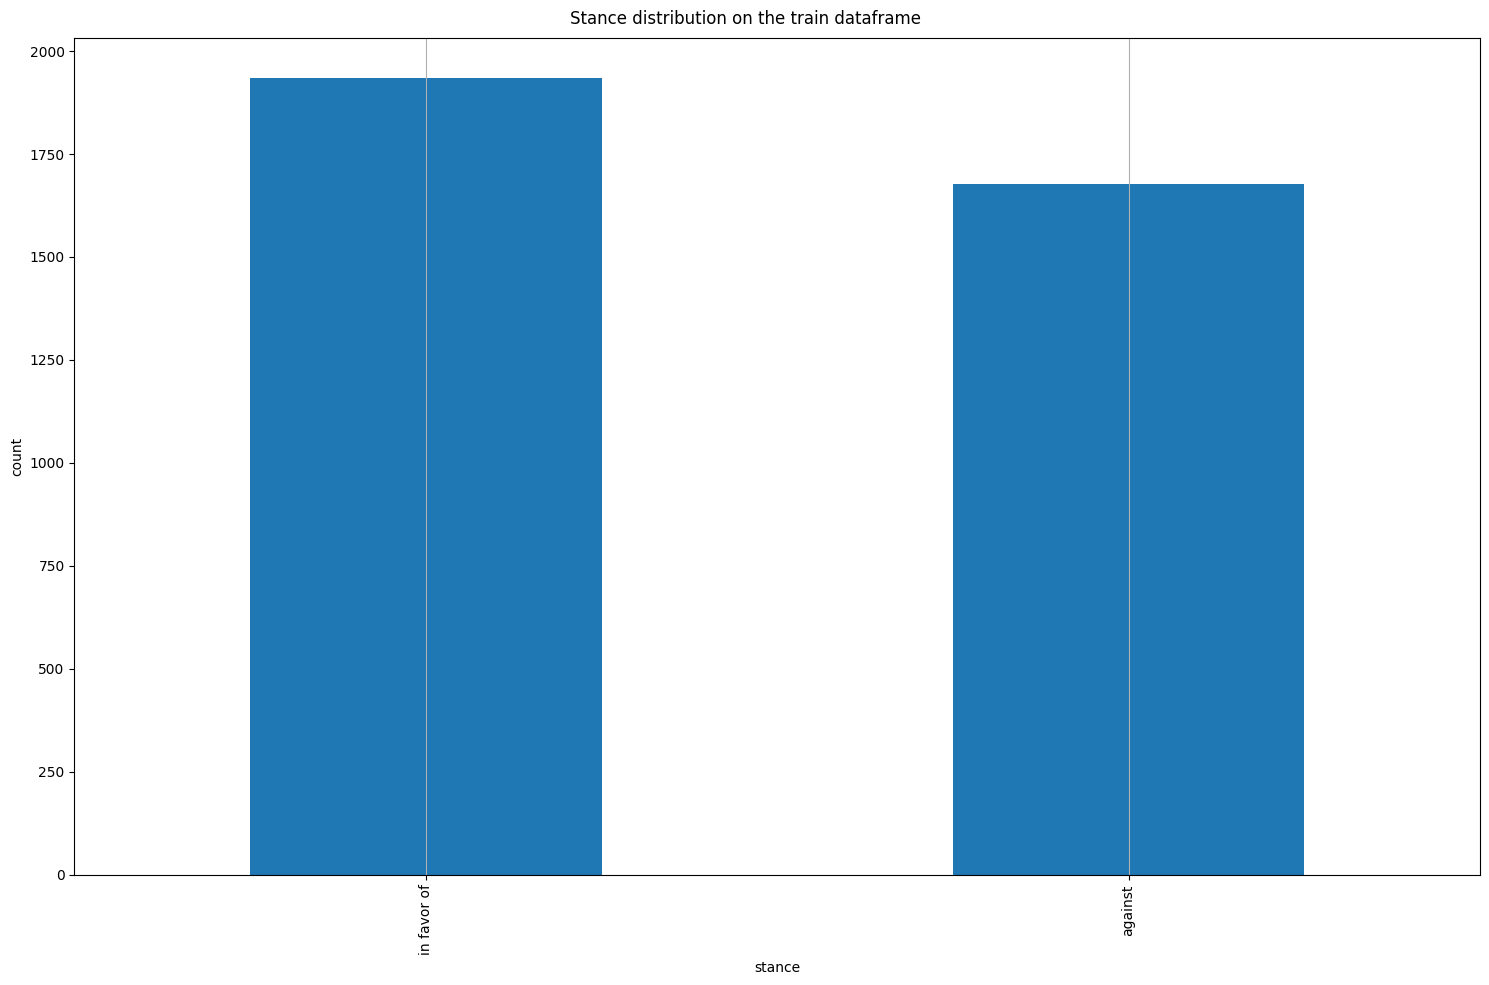

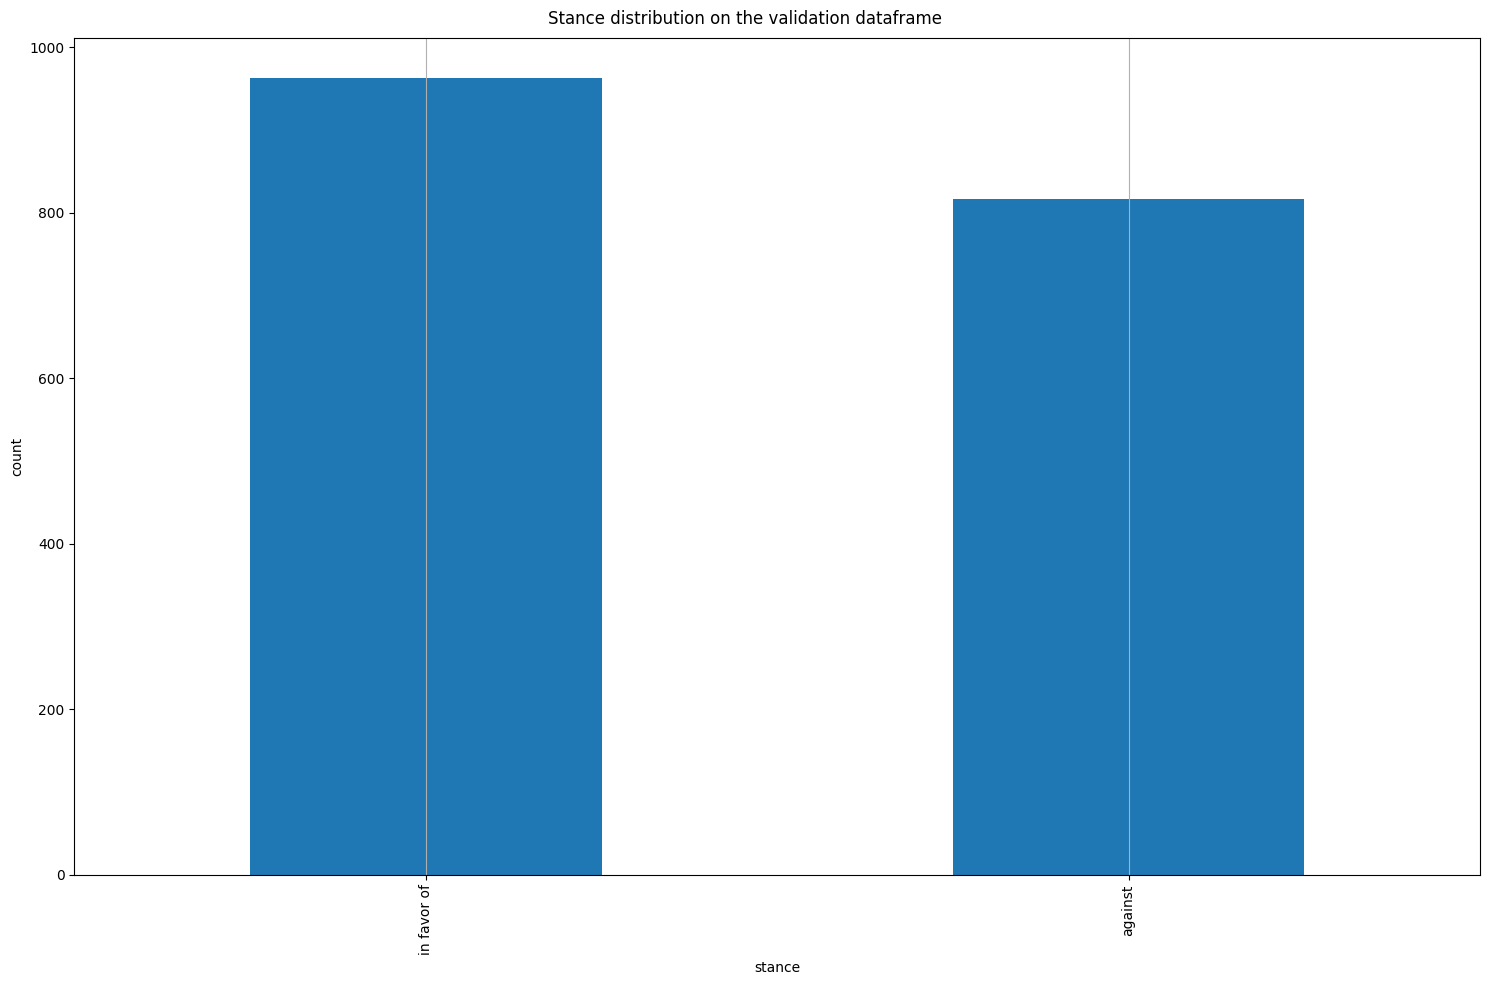

In [11]:
plot_stance_distribution(arguments_train_df, title='Stance distribution on the train dataframe')
plot_stance_distribution(arguments_val_df, title='Stance distribution on the validation dataframe')

In [12]:
import matplotlib.pyplot as plt 

def plot_sentiment_distribution(labels_df: pd.DataFrame, title: str = 'Sentiment values distribution'):
    fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize=(15, 10))
    labels_train_df.sum().plot(ax=ax, kind='bar')


    # Show just the x grid
    ax.grid(axis='x')

    # set title and axis labels
    plt.suptitle('Sentiment values distribution')

    ax.set_xlabel('sentiment values')
    ax.set_ylabel('count')

    plt.tight_layout()

    plt.show()

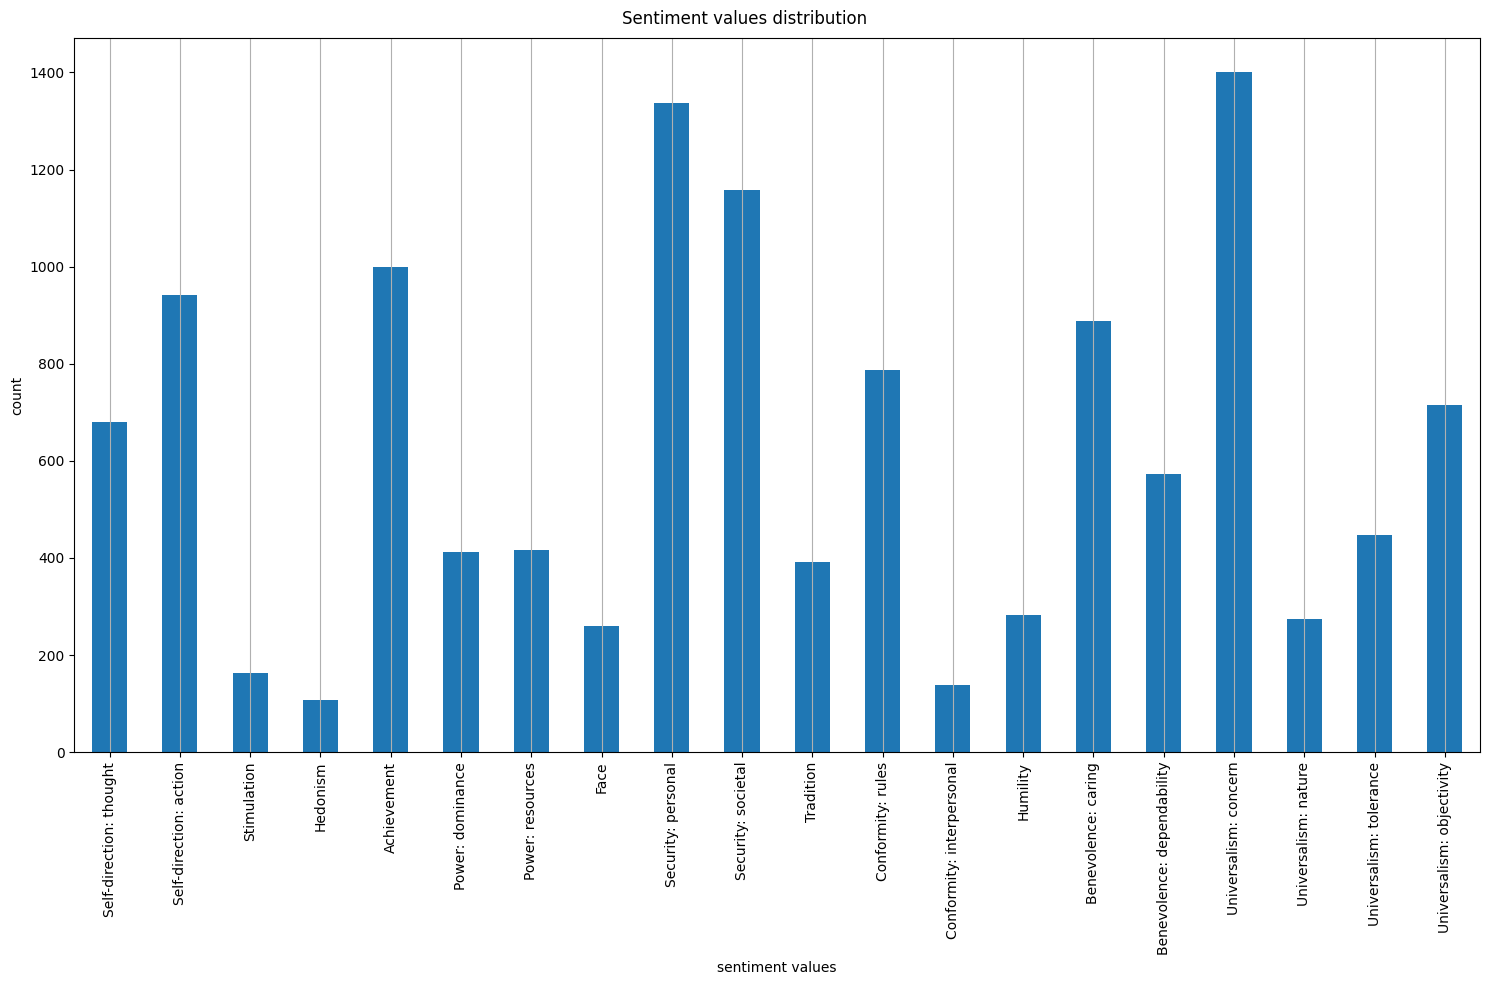

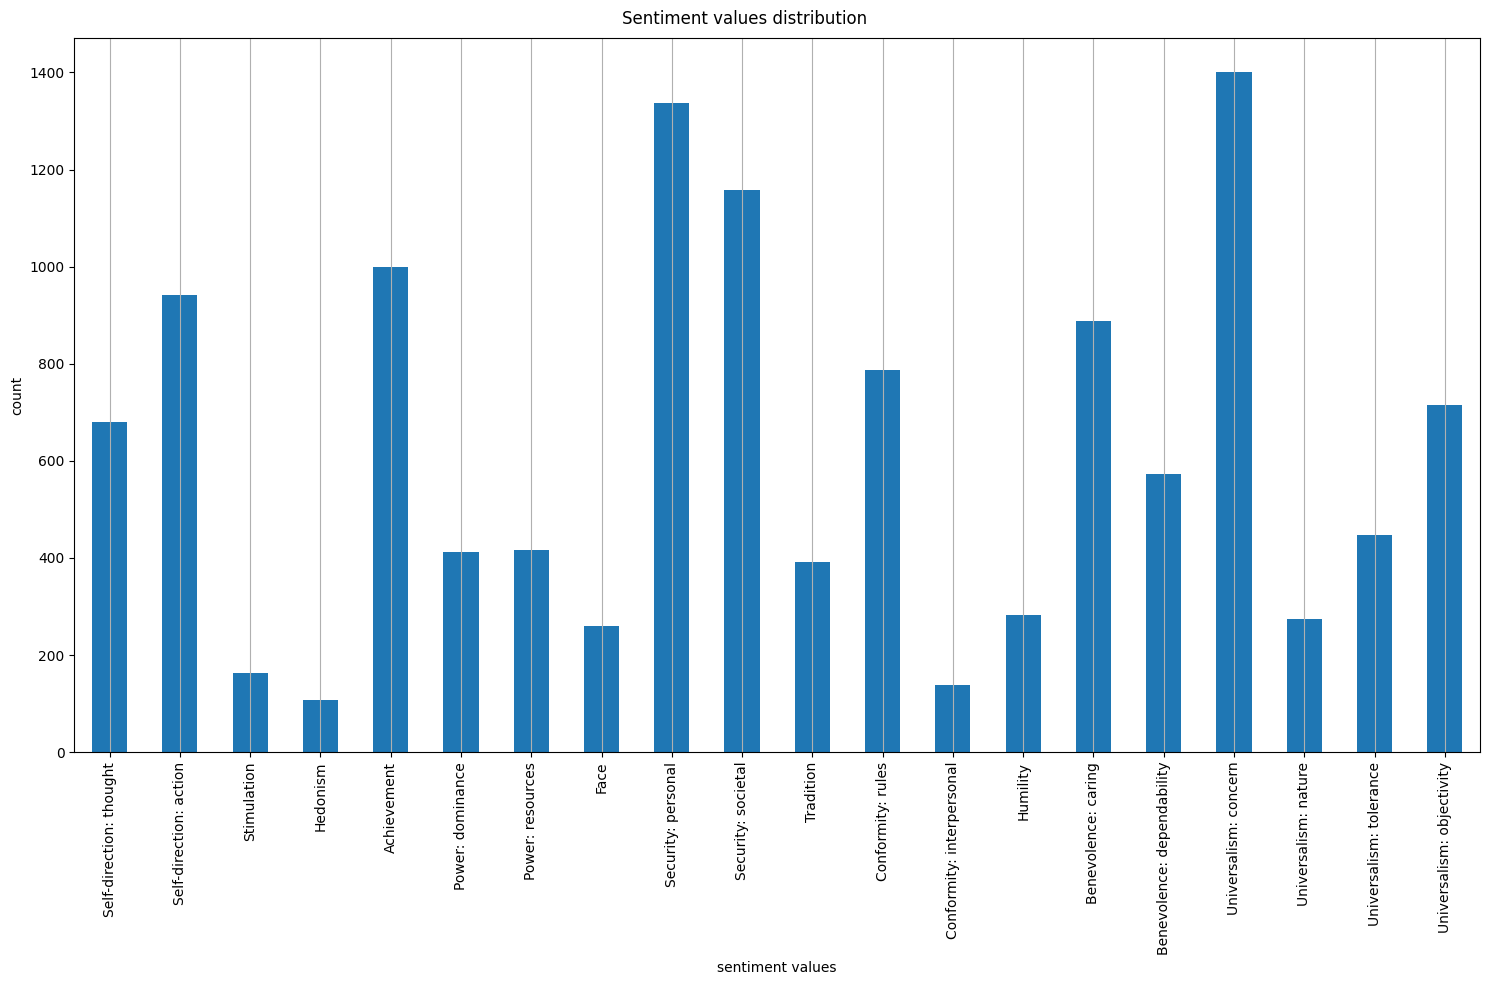

In [13]:
plot_sentiment_distribution(labels_train_df, title='Sentiment values distribution on the train dataframe')
plot_sentiment_distribution(labels_val_df, title='Sentiment values distribution on the validation dataframe')

In [14]:
labels_train_df.shape

(3613, 20)

In [15]:
train_labels_frequencies = (labels_train_df.sum() / len(labels_train_df)).to_numpy()

In [16]:
labels_frequencies = labels_train_df.value_counts() 

In [17]:
import numpy as np

def plot_sequence_length_analysis(arguments_df: pd.DataFrame, df_name: str = 'dataset'):
    """Analyse the length of the premises + stances + conclusions
    Parameters
    ----------
    df : DataFrame
        A pandas dataframe.
    """
    # Length of each training sentence
    train_sentences_lenghts = arguments_df.Premise.str.len() + arguments_df.Conclusion.str.len() + 1

    # Histogram of the sentences length distribution
    hist, bin_edges = np.histogram(train_sentences_lenghts, bins=np.max(train_sentences_lenghts) + 1, density=True) 
    # Cumulative distribution of the sentences length
    C = np.cumsum(hist)*(bin_edges[1] - bin_edges[0])

    plt.figure(figsize=(15, 7))
    plt.subplot(1, 2, 1)
    plt.plot(bin_edges[1:], hist)
    plt.title(f'Distribution of the sentence length across the {df_name}')
    plt.xlabel('Sentence length')
    plt.grid()
    plt.subplot(1, 2, 2)
    plt.plot(bin_edges[1:], C)
    plt.title(f'Comulative distribution of the sentence length across the {df_name}')
    plt.xlabel('Sentence length')
    plt.grid()
    plt.show()

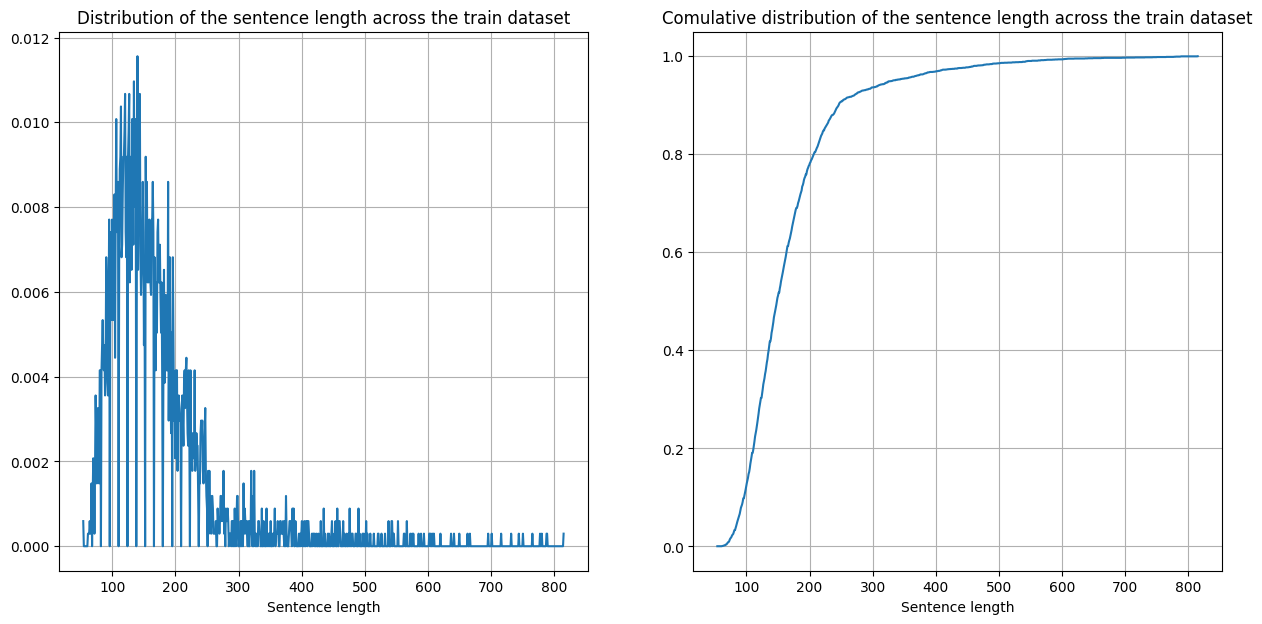

In [18]:
plot_sequence_length_analysis(arguments_train_df, df_name='train dataset')

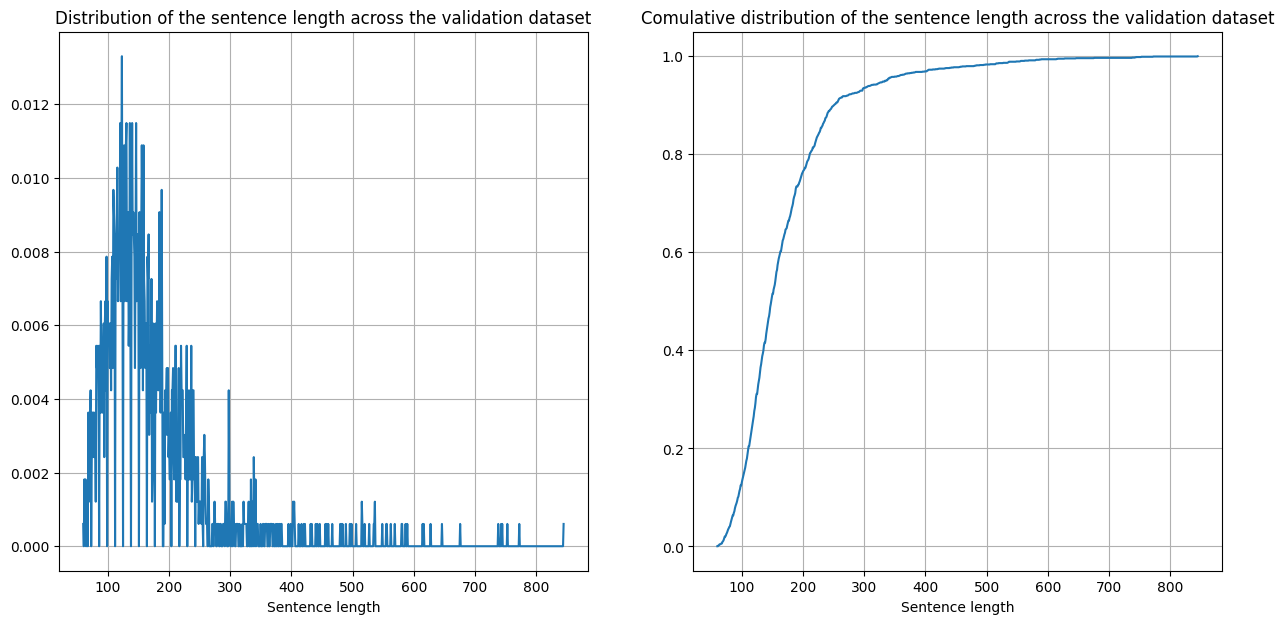

In [19]:
plot_sequence_length_analysis(arguments_val_df, df_name='validation dataset')

In [20]:
quantile_95 = (arguments_train_df.Premise.str.len() + arguments_train_df.Conclusion.str.len() + 1).quantile(.95, interpolation='nearest')

print(f'The 95th quantile of input lengths in the train dataset is: {quantile_95}')

The 95th quantile of input lengths in the train dataset is: 331


In [21]:
total_corpus = arguments_train_df.Conclusion.tolist() + arguments_train_df.Premise.tolist()

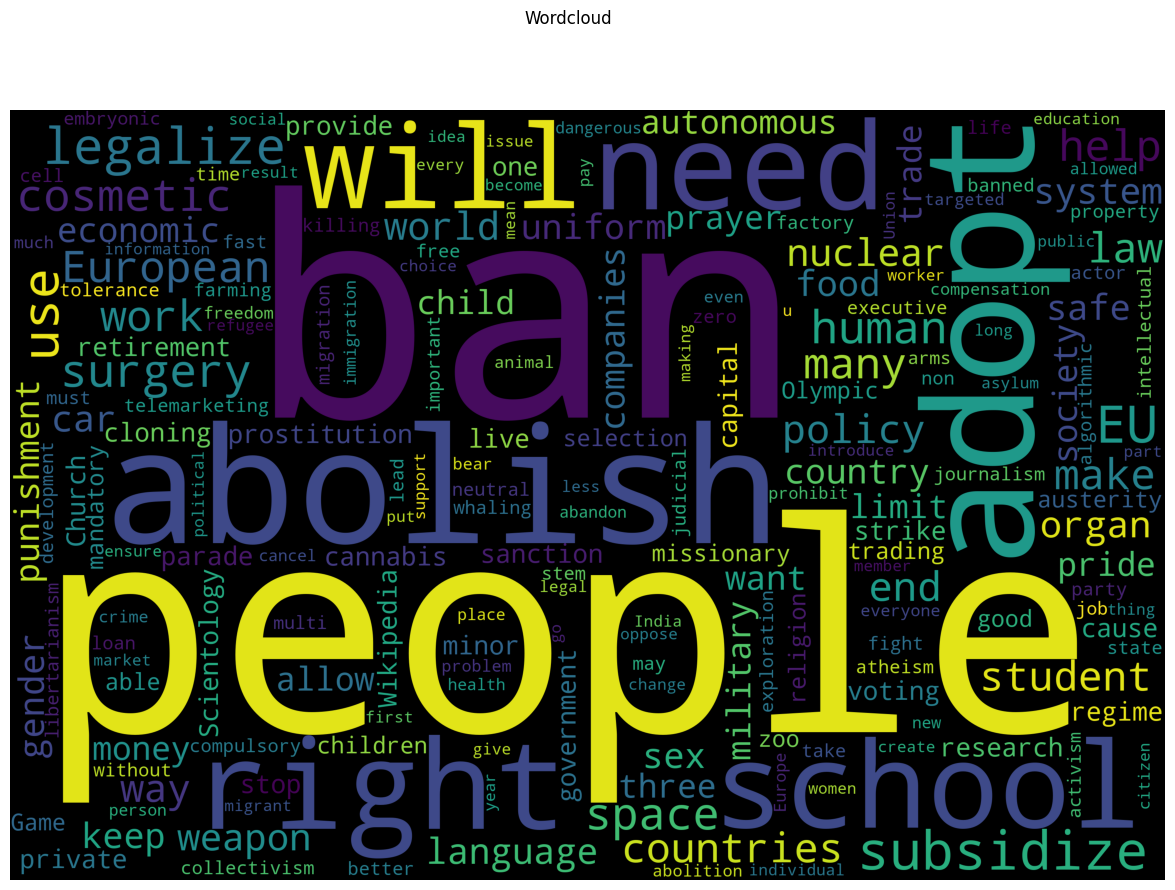

In [22]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

word_cloud = WordCloud(width=3000, height=2000, collocations=False, stopwords=STOPWORDS).generate(' '.join(total_corpus))
plt.figure(figsize=(15, 10))
plt.imshow(word_cloud)
plt.suptitle('Wordcloud') 
plt.axis("off")
plt.show()

In [23]:
# Importing the libraries needed
import pandas as pd
import torch
import transformers
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertModel, DistilBertTokenizer

In [24]:
# Setting up the device for GPU usage

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [25]:
len(labels_train_df.columns.to_list())

20

In [26]:
#label_to_number_dict = {l: i for i, l in enumerate(labels_train_df.columns.to_list()[1:])}
#number_to_label_dict = {i: l for l, i in label_to_number_dict.items()}

In [27]:
#model_name = 'distilbert-base-cased'
model_name = 'roberta-base'

In [28]:
from transformers import AutoTokenizer

# Defining some key variables that will be used later on in the training
MAX_LEN = quantile_95
TRAIN_BATCH_SIZE = 4
VAL_BATCH_SIZE = 4
EPOCHS = 5
LEARNING_RATE_BASE = 1e-05
LEARNING_RATE_HEAD = 1e-03
tokenizer = AutoTokenizer.from_pretrained(model_name, problem_type="multi_label_classification")


num_added_toks = tokenizer.add_tokens(['[FAV]', '[AGN]'], special_tokens=True) ##This line is updated

stance_encoder = {'in favor of': '[FAV]', 'against': '[AGN]'}

###The tokenizer has to be saved if it has to be reused
#tokenizer.save_pretrained(<output_dir>)

In [29]:
# Change from dataframe to numpy

class Triage(Dataset):
    def __init__(self, arguments_df: pd.DataFrame, labels_df: pd.DataFrame, tokenizer, max_len):
        self.len = len(arguments_df)
        self.arguments_data = arguments_df
        self.labels_data = labels_df
        self.tokenizer = tokenizer
        self.max_len = max_len
    # Casual number between 1 and 3 and depending on that give premise conclusion or both.
    def __getitem__(self, index):
        premise = self.arguments_data.Premise[index]
        conclusion = self.arguments_data.Conclusion[index]
        stance = stance_encoder[self.arguments_data.Stance[index]]
        
        whole_text = premise + f' {stance} ' + conclusion
        
        '''inputs = self.tokenizer.encode_plus(
            input_text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding=True,
            #return_token_type_ids=False,
            truncation=True
        )'''
        ''' ids = inputs['input_ids']
        mask = inputs['attention_mask']'''

        return premise, conclusion, whole_text, self.labels_data.loc[index].to_list()
    
    def __len__(self):
        return self.len

In [30]:
# Creating the dataset and dataloader for the neural network
train_set = Triage(arguments_train_df, labels_train_df, tokenizer, MAX_LEN)
val_set = Triage(arguments_val_df, labels_val_df, tokenizer, MAX_LEN)
test_set = Triage(arguments_test_df, labels_test_df, tokenizer, MAX_LEN)

In [31]:
from random import sample

def collate_batch(batch: tuple, augment_data: bool):
    input_texts = []
    labels = []
    
    for p, c, w, l in batch:
        # Get random text among premise, conclusion and whole text
        if augment_data:
            [result] = sample([p, c, w], 1)
        else:
            result = w
        input_texts.append(result)
        labels.append(l)
    
    inputs = tokenizer(
        input_texts,
        None,
        add_special_tokens=True,
        max_length=MAX_LEN,
        padding=True,
        truncation=True,
        return_tensors='pt')

    ids = inputs['input_ids']
    mask = inputs['attention_mask']
    
    return {
        'ids': ids,
        'mask': mask,
        'labels': torch.tensor(labels, dtype=torch.float32)
    }

dataloader_params = {
    'num_workers': 0,
    'collate_fn': collate_batch
}

train_params = {'num_workers': 0, 'collate_fn': lambda x: collate_batch(x, augment_data=True), 'shuffle': True,
                'batch_size': TRAIN_BATCH_SIZE}

test_params = {'num_workers': 0, 'collate_fn': lambda x: collate_batch(x, augment_data=False),
              'batch_size': VAL_BATCH_SIZE}


In [32]:
training_loader = DataLoader(train_set, **train_params)
val_loader = DataLoader(val_set, **test_params)
test_loader = DataLoader(test_set, **test_params)

In [33]:
# next(iter(val_loader))

In [34]:
# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model. 
'''
class DistillBERTClass(torch.nn.Module):
    def __init__(self):
        super(DistillBERTClass, self).__init__()
        self.l1 = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, len(labels_train_df.columns) - 1)

    def forward(self, input_ids, attention_mask):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output'''

'\nclass DistillBERTClass(torch.nn.Module):\n    def __init__(self):\n        super(DistillBERTClass, self).__init__()\n        self.l1 = DistilBertModel.from_pretrained("distilbert-base-uncased")\n        self.pre_classifier = torch.nn.Linear(768, 768)\n        self.dropout = torch.nn.Dropout(0.3)\n        self.classifier = torch.nn.Linear(768, len(labels_train_df.columns) - 1)\n\n    def forward(self, input_ids, attention_mask):\n        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)\n        hidden_state = output_1[0]\n        pooler = hidden_state[:, 0]\n        pooler = self.pre_classifier(pooler)\n        pooler = torch.nn.ReLU()(pooler)\n        pooler = self.dropout(pooler)\n        output = self.classifier(pooler)\n        return output'

In [35]:
from transformers import AutoModelForSequenceClassification


model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(labels_train_df.columns),
    ignore_mismatched_sizes=True,
    problem_type="multi_label_classification")

model.resize_token_embeddings(len(tokenizer))

model.to(device)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50267, 768)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm

In [36]:
model

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50267, 768)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm

In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha, gamma=1):
        super(FocalLoss, self).__init__()
        self.alpha = torch.tensor(alpha)
        self.gamma = gamma

    def forward(self, inputs, targets):
        
        #train_labels_frequencies
        # bce_loss = F.binary_cross_entropy_with_logits(inputs,  targets.float())
        alpha = self.alpha.to(inputs.device)
        
        probs = inputs.sigmoid()
        
        p_t = targets * probs + (1 - targets) * (1 - probs)
        alpha_t = targets * (1 - alpha) + (1 - targets) * alpha
        
        loss = - alpha_t * (1 - p_t) ** self.gamma * torch.log(p_t)

        return loss.mean()

In [38]:

# Creating the loss function and optimizer
#loss_function = torch.nn.BCEWithLogitsLoss()
loss_function = FocalLoss(train_labels_frequencies)
optimizer = torch.optim.Adam(params=[
                {'params': model.roberta.parameters(), 'lr': LEARNING_RATE_BASE},
                {'params': model.classifier.parameters(), 'lr': LEARNING_RATE_HEAD}
            ])

In [39]:
# Function to calcuate the accuracy of the model
'''
def calculate_accuracy(out, targets, threshold=.5):
    out = out.sigmoid()
    return ((out > threshold) == targets.bool()).float().mean().item()'''

'\ndef calculate_accuracy(out, targets, threshold=.5):\n    out = out.sigmoid()\n    return ((out > threshold) == targets.bool()).float().mean().item()'

OrderedDict([('roberta.embeddings.position_ids', tensor([[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
          14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
          28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
          42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
          56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
          70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
          84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
          98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
         112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
         126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
         140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
         154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
   

In [41]:
import os
from typing import Optional

class Checkpoint():
    def __init__(self, model: AutoModelForSequenceClassification, path: Optional[str] = None) -> None:
        self.model = model
        self.last_metric = .0
        self.path = path if path is not None else os.path.join('checkpoints', 'best_model.pth')

        os.makedirs(os.path.dirname(self.path), exist_ok=True)

    def save_best(self, new_metric: float, **kwargs) -> None:
        #print(self.model.state_dict())
        if new_metric > self.last_metric:
            checkpoint = { k: np.array(v) for k, v in kwargs.items() }
            checkpoint['model_state_dict'] = self.model.state_dict(),

            torch.save(checkpoint, self.path)

        self.last_metric = new_metric
    
    def load_best(self) -> None:
        checkpoint = torch.load(self.path)
        model.load_state_dict(checkpoint['model_state_dict'][0])


In [42]:
class EarlyStopping():
    def __init__(self, patience=3, tolerance=.5) -> None:
        self.patience = patience
        self.tolerance = tolerance
        self.trigger_times = 0
        self.max_metric = 0.
        self.stop_condition = False

    def update(self, metric: float):
        if self.max_metric - metric <= self.tolerance:
            self.trigger_times = 0
            if metric > self.max_metric:
                self.max_metric = metric
        else:
            self.trigger_times += 1

            if self.trigger_times >= self.patience:
                self.stop_condition = True

    def is_stop_condition_met(self):
        return self.stop_condition


In [43]:
from IPython.display import DisplayHandle
import os
import sys
from time import time
from transformers import AutoModelForSequenceClassification
from typing import Optional
from sklearn.metrics import f1_score


'''def get_dataset_predictons(dataloader: DataLoader):
    predictions = np.empty(shape=(0, len(labels_test_df.columns)), dtype=np.uint8)
    true_labels = np.empty(shape=(0, len(labels_test_df.columns)), dtype=np.uint8)
    
    for batch_idx, data in enumerate(dataloader, 0):
        # Get the data
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
    
        # Compute output
        outputs = model(ids, mask)
        
        #results = outputs.logits.sigmoid()
        results = outputs.logits > 0
        results = results.cpu().numpy()
        results = results.astype(np.uint8)
        
        predictions = np.concatenate((predictions, results), axis=0)
        
        targets = data['labels'].cpu().numpy().astype(np.uint8)
        true_labels = np.concatenate((true_labels, targets), axis=0)
        
        #print(results)
        #print(targets.cpu().numpy().astype(np.uint8))
    return predictions, true_labels'''
    
def get_dataset_predictons(dataloader: DataLoader):
    predictions = np.empty(shape=(0, len(labels_test_df.columns)), dtype=np.uint8)
    true_labels = np.empty(shape=(0, len(labels_test_df.columns)), dtype=np.uint8)
    
    for batch_idx, data in enumerate(dataloader, 0):
        with torch.no_grad():
            # Get the data
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
        
            # Compute output
            outputs = model(ids, mask)

            preds = outputs.logits
            
            preds = preds.cpu().numpy()
            
            predictions = np.concatenate((predictions, preds), axis=0)

            targets = data['labels'].cpu().numpy().astype(np.uint8)
            true_labels = np.concatenate((true_labels, targets), axis=0)

    return predictions, true_labels

def _loss_validate(val_dataloader: DataLoader, print_result: bool = True):
    print()
    # disp = display('', display_id=True)

    # Variables for accumulating the loss1 and loss2
    running_loss = .0
    running_accuracy = .0

    # Number of evaluated samples
    batch_step = 0

    # Starting time
    start_time = time()

    torch.cuda.empty_cache()

    preds, y_true = get_dataset_predictons(val_dataloader)
    
    loss = loss_function(torch.Tensor(preds).to(device, dtype=torch.float32),
                         torch.Tensor(y_true).to(device, dtype=torch.float32))
    
    y_pred = preds > 0
    y_pred = y_pred.astype(np.uint8)

    f1_macro = f1_score(y_true=y_true, y_pred=y_pred, average='macro')

    
    final_time = time() - start_time
    
    if print_result:
        print(
            f'validate: ' +
            f'{final_time:.0f}s, ' +
            f'validation loss: {loss:.3g}, '
            f'validation f1 macro: {f1_macro * 100:.3g} %' +
            '               '
            )

    return loss, f1_macro



def train(train_dataloader: DataLoader, val_dataloader: DataLoader, model: AutoModelForSequenceClassification, 
          epochs: int = 5, steps_validate: int = 100, checkpoint_path: Optional[str] = None,
          reload_best_weights: bool = True) -> None:

    checkpoint = Checkpoint(model, checkpoint_path)
    # Create path to save checkpoints
    '''if checkpoint_path is None:
        checkpoint_path = os.path.join('checkpoints', 'checkpoints.pth')''';

    #os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)
    
    early_stopping = EarlyStopping()
    
    train_loss_history = []
    val_loss_history = []
    val_f1_macro_history = []

    # Total steps to perform
    # tot_steps = len(train_dataloader) * epochs
    # Number of step already done
    n_steps = 0
    
    model.train()

    # Iterate across the epochs
    for epoch in range(epochs):
        # Set up display element
        #disp = display('', display_id=True)

        # Remove unused tensors from gpu memory
        torch.cuda.empty_cache()

        # Initialize running losses
        running_loss = 0.0
        
        optimizer.zero_grad()

        start_time = time()

        # Number of batches for the current update step
        batch_steps = 0

        for batch_idx, data in enumerate(train_dataloader, 0):
            # Increment the number of batch steps
            batch_steps += 1

            # Get the data
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            targets = data['labels'].to(device, dtype = torch.float32)
        
            # Compute output
            outputs = model(ids, mask)
            
            # Loss
            loss = loss_function(outputs.logits, targets)
            running_loss += loss.item()

            optimizer.zero_grad()
            #nb_tr_steps += 1
            loss.backward()
            
            # When using GPU
            optimizer.step()

            # Evaluate on validation set
            if batch_idx % steps_validate == steps_validate - 1:
                torch.cuda.empty_cache()
                # Compute both the token importances validation loss and the answer generation validation loss
                val_loss, val_f1_macro = _loss_validate(val_dataloader)
                
                # Update validation loss history
                val_loss_history.append([n_steps, val_loss.item()])
                val_f1_macro_history.append([n_steps, val_f1_macro])

                torch.cuda.empty_cache()
                
                checkpoint.save_best(val_f1_macro, train_loss_history=train_loss_history, val_loss_history=val_loss_history,
                                     val_f1_macro_history=val_f1_macro_history)
                
                early_stopping.update(val_f1_macro)

                if early_stopping.is_stop_condition_met():
                    return train_loss_history, val_loss_history, val_f1_macro_history


            # Update training history and print           
            train_loss_history.append(loss.item())
            
            epoch_time = time() - start_time
            batch_time = epoch_time / (batch_idx + 1)
            
            # TODO: function to print batch string
            print(
                f'epoch: {epoch + 1}/{epochs}, ' +
                f'{batch_idx + 1}/{len(train_dataloader)}, '
                f'{epoch_time:.0f}s {batch_time * 1e3:.0f}ms/step, ' +
                f'lr base: {optimizer.param_groups[0]["lr"]:.3g} lr head: {optimizer.param_groups[1]["lr"]:.3g}, ' +
                f'loss: {running_loss / batch_steps:.3g}, ' +
                '               ',
                end='\r'
                )

            n_steps += 1

        torch.cuda.empty_cache()
        # Compute both the token importances validation loss and the answer generation validation loss
        val_loss, val_f1_macro = _loss_validate(val_dataloader, print_result=False)
        # Update validation loss history
        val_loss_history.append([n_steps, val_loss.item()])
        val_f1_macro_history.append([n_steps, val_f1_macro])

        torch.cuda.empty_cache()

        print('-----------------------------------------------------------------------------------------------')
        print(
            f'epoch: {epoch + 1}/{epochs}, ' +
            f'{epoch_time:.0f}s, ' +
            f'lr base: {optimizer.param_groups[0]["lr"]:.3g} lr head: {optimizer.param_groups[1]["lr"]:.3g}, ' +
            f'loss: {running_loss / batch_steps:.3g} val loss:, {val_loss:.3g}, ' + 
            f'val f1 macro: {val_f1_macro * 100:.3g} %'
            )
        print('===============================================================================================')
        
        checkpoint.save_best(val_f1_macro, train_loss_history=train_loss_history, val_loss_history=val_loss_history,
                        val_f1_macro_history=val_f1_macro_history)

        early_stopping.update(val_f1_macro)

        if early_stopping.is_stop_condition_met():
            return train_loss_history, val_loss_history, val_f1_macro_history

    if reload_best_weights:
        checkpoint.load_best()
        
    print(val_f1_macro_history)
        

    return np.array(train_loss_history), np.array(val_loss_history), np.array(val_f1_macro_history)


In [44]:
train_loss_history, val_loss_history, val_f1_macro_history = train(training_loader, val_loader, model, epochs=EPOCHS,
                                                                   steps_validate=200)

epoch: 1/5, 199/904, 38s 192ms/step, lr base: 1e-05 lr head: 0.001, loss: 0.0896,                
validate: 18s, validation loss: 0.0835, validation f1 macro: 34.1 %               
epoch: 1/5, 399/904, 97s 243ms/step, lr base: 1e-05 lr head: 0.001, loss: 0.0865,                
validate: 16s, validation loss: 0.0791, validation f1 macro: 36.8 %               
epoch: 1/5, 599/904, 150s 251ms/step, lr base: 1e-05 lr head: 0.001, loss: 0.0838,                
validate: 16s, validation loss: 0.0799, validation f1 macro: 39.2 %               
epoch: 1/5, 799/904, 203s 254ms/step, lr base: 1e-05 lr head: 0.001, loss: 0.083,                 
validate: 16s, validation loss: 0.0781, validation f1 macro: 38.2 %               
epoch: 1/5, 904/904, 237s 262ms/step, lr base: 1e-05 lr head: 0.001, loss: 0.0825,                
-----------------------------------------------------------------------------------------------
epoch: 1/5, 237s, lr base: 1e-05 lr head: 0.001, loss: 0.0825 val loss:, 0.0768

In [45]:
'''checkpoint = torch.load('checkpoints/best_model.pth')

# Get loss history and validation loss history
model.load_state_dict(checkpoint['model_state_dict'][0])
train_loss_history = checkpoint['train_loss_history']
val_loss_history = checkpoint['val_loss_history']
val_f1_macro_history = checkpoint['val_f1_macro_history']''';

In [46]:
import matplotlib.pyplot as plt
import numpy as np

def _plot_loss_subplot(train_loss_history: np.ndarray, val_loss_history: np.ndarray, subplot_index: int, n_batches: int,
                       use_log_scale: bool = False) -> None:
    plt.subplot(2, 2, subplot_index)

    plt.title(f'Loss history{" using log scale" if use_log_scale else ""}')

    plt.plot(train_loss_history, label='Training loss')
    
    averaged_train_history = np.convolve(train_loss_history, np.ones(n_batches)/n_batches, mode='valid')
    
    plt.plot(np.linspace(0, len(train_loss_history), len(averaged_train_history)), averaged_train_history,
             label=f'Training loss averaged on {n_batches} batches')

    # Plot validation history if present
    plt.plot(val_loss_history[:,0], val_loss_history[:,1], 'r*', label=f'Validation loss')
    
    plt.xlabel('iterations')
    
    # Use log scale if specified
    if use_log_scale:
        plt.yscale('log')
        plt.ylabel(f'loss (log)')
    else:
        plt.ylabel('loss')

    plt.legend()
    
def _plot_f1_subplot(validation_f1_history: np.ndarray, subplot_index: int) -> None:
    plt.subplot(2, 1, subplot_index)

    plt.title(f'F1 macro history on the validation set')

    #plt.plot(val_f1_macro_history)
    plt.plot(validation_f1_history[:,0], validation_f1_history[:,1], 'r')
    
    # averaged_train_history = np.convolve(train_history, np.ones(n_batches)/n_batches, mode='valid')
    
    #plt.plot(np.linspace(0, len(train_history), len(averaged_train_history)), averaged_train_history,
    #         label=f'Training {metric} averaged on {n_batches} batches')
    
    #plt.plot(np.convolve(training_loss_history[:,loss_index], np.ones(n_batches)/n_batches, mode='valid'), 
    #         label=f'Training loss averaged on {n_batches} batches')

    # Plot validation history if present
    #plt.plot(validation_history[:,0], validation_history[:,1], 'r*', label=f'Validation {metric}')
    
    plt.xlabel('iterations')
    
    # Use log scale if specified
    #if use_log_scale:
    #    plt.yscale('log')
    #    plt.ylabel(f'{metric} (log)')
    #else:
    plt.ylabel('F1 macro')

    #plt.legend()


def plot_training_history(train_loss_history: np.ndarray, val_loss_history: np.ndarray,
                          val_f1_macro_history: np.ndarray) -> None:
    n_batches = 50

    plt.figure(figsize=(15,12))
    plt.subplot(2, 2, 1)
    plt.suptitle('Training procedure analysis')
    
    # Plot loss history
    _plot_loss_subplot(train_loss_history, val_loss_history, 1, n_batches, use_log_scale=False)
    
    # Plot log loss history
    _plot_loss_subplot(train_loss_history, val_loss_history, 2, n_batches, use_log_scale=True)

    # Plot validation F1 history
    _plot_f1_subplot(val_f1_macro_history, 2)

    # Plot loss history of the Seq2seq module in log scale
    #_plot_loss_subplot(train_accuracy_history, validation_accuracy_history, 4, n_batches, use_log_scale=True)
    
    plt.show()

list

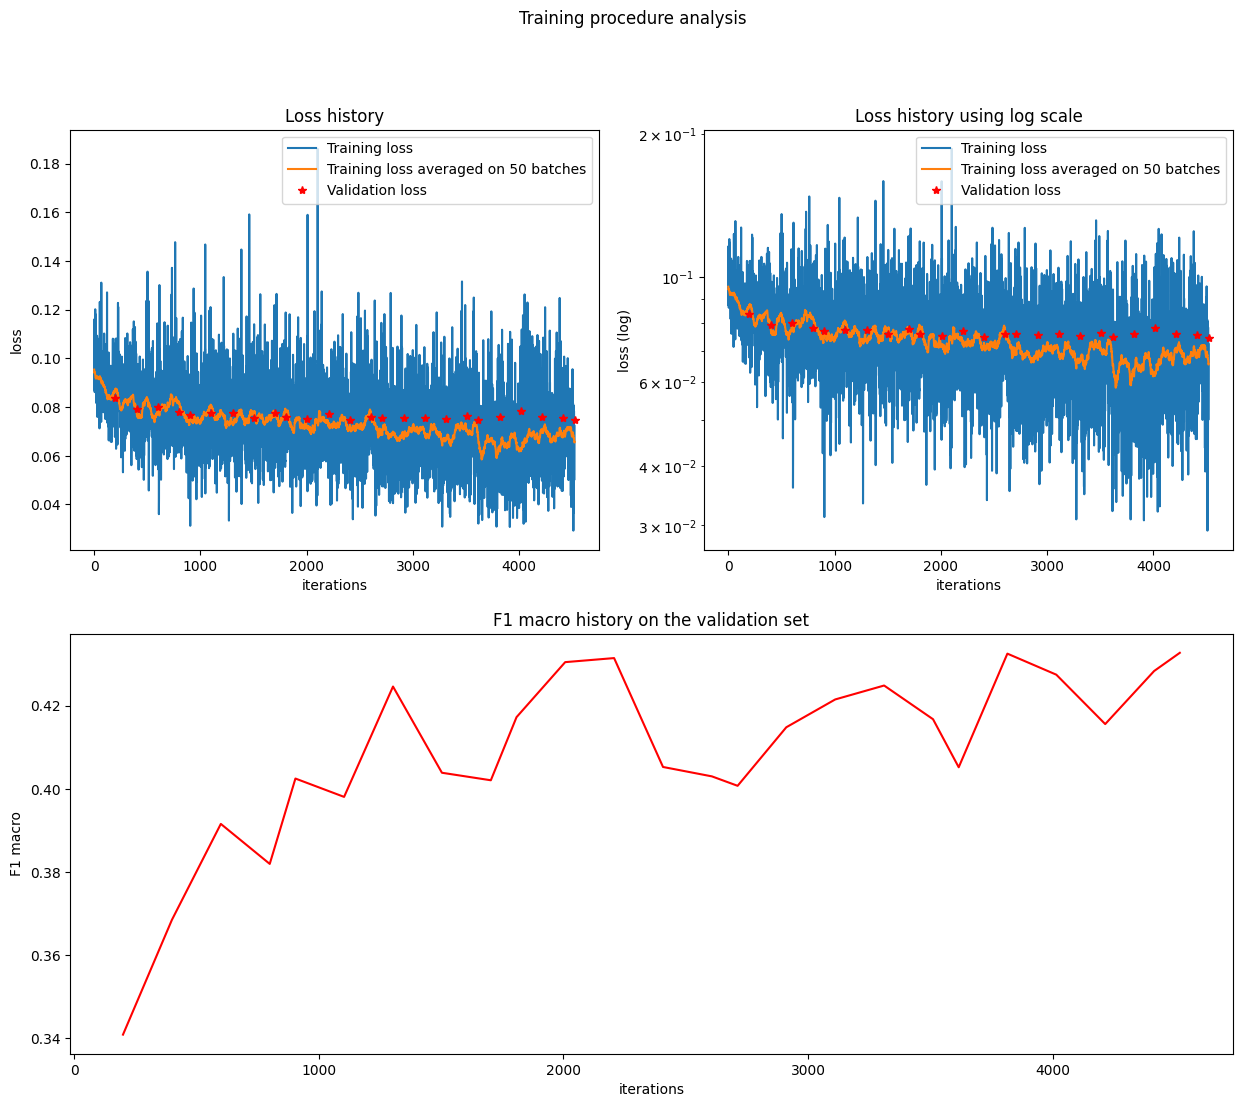

In [50]:
plot_training_history(np.array(train_loss_history), np.array(val_loss_history), np.array(val_f1_macro_history))

In [51]:
def predict(dataloader: DataLoader):
    predictions = np.empty(shape=(0, len(labels_test_df.columns)), dtype=np.uint8)
    true_labels = np.empty(shape=(0, len(labels_test_df.columns)), dtype=np.uint8)
    
    for batch_idx, data in enumerate(dataloader, 0):
        # Get the data
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
    
        # Compute output
        outputs = model(ids, mask)
        
        #results = outputs.logits.sigmoid()
        results = outputs.logits > 0
        results = results.cpu().numpy()
        results = results.astype(np.uint8)
        
        predictions = np.concatenate((predictions, results), axis=0)
        
        targets = data['labels'].cpu().numpy().astype(np.uint8)
        true_labels = np.concatenate((true_labels, targets), axis=0)
        
        #print(results)
        #print(targets.cpu().numpy().astype(np.uint8))
    return predictions, true_labels

In [52]:
y_pred, y_true = predict(val_loader)

In [53]:
# Validation f1-score
from sklearn.metrics import f1_score

In [98]:
'''def f1_score_per_label(y_pred, y_true, value_classes):
    """Compute label-wise and averaged F1-scores"""
    f1_scores = {}
    for i, v in enumerate(value_classes):
        f1_scores[v] = round(f1_score(y_true[:, i], y_pred[:, i], zero_division=0), 2)

    f1_scores['avg-f1-score'] = round(np.mean(list(f1_scores.values())), 2)

    return f1_scores''';

In [99]:
'''f1_score_per_label(y_pred, y_true, labels_train_df.columns.to_list())''';

{'Self-direction: thought': 0.44,
 'Self-direction: action': 0.54,
 'Stimulation': 0.21,
 'Hedonism': 0.3,
 'Achievement': 0.67,
 'Power: dominance': 0.31,
 'Power: resources': 0.48,
 'Face': 0.2,
 'Security: personal': 0.71,
 'Security: societal': 0.66,
 'Tradition': 0.4,
 'Conformity: rules': 0.52,
 'Conformity: interpersonal': 0.18,
 'Humility': 0.18,
 'Benevolence: caring': 0.59,
 'Benevolence: dependability': 0.3,
 'Universalism: concern': 0.65,
 'Universalism: nature': 0.5,
 'Universalism: tolerance': 0.32,
 'Universalism: objectivity': 0.39,
 'avg-f1-score': 0.43}

In [54]:
# Validation f1-score
from sklearn.metrics import f1_score

y_pred, y_true = predict(val_loader)
f1_macro = f1_score(y_true=y_true, y_pred=y_pred, average='macro')
print(f'Validation f1-score macro on the validation set: {f1_macro:.3f}')

Validation f1-score macro on the validation set: 0.426


In [91]:
from sklearn.metrics import classification_report

class_report_val = classification_report(y_true=y_true, y_pred=y_pred, target_names=labels_train_df.columns.to_list(),
                                     zero_division=0, output_dict=True)

print('Classification report for the validation set:')
print(classification_report(y_true=y_true, y_pred=y_pred,
                            target_names=labels_train_df.columns.to_list(), zero_division=0))

Classification report for the validation set:
                            precision    recall  f1-score   support

   Self-direction: thought       0.46      0.69      0.55       308
    Self-direction: action       0.43      0.81      0.56       454
               Stimulation       0.09      0.73      0.16        84
                  Hedonism       0.15      0.86      0.26        65
               Achievement       0.61      0.58      0.59       512
          Power: dominance       0.27      0.68      0.38       198
          Power: resources       0.34      0.73      0.47       209
                      Face       0.11      0.76      0.19       122
        Security: personal       0.62      0.75      0.68       662
        Security: societal       0.70      0.66      0.68       571
                 Tradition       0.32      0.77      0.46       176
         Conformity: rules       0.41      0.64      0.50       389
 Conformity: interpersonal       0.11      0.77      0.19        69
 

In [92]:
print(class_report_val)

{'Self-direction: thought': {'precision': 0.45788336933045354, 'recall': 0.6883116883116883, 'f1-score': 0.5499351491569391, 'support': 308}, 'Self-direction: action': {'precision': 0.42675893886966554, 'recall': 0.8149779735682819, 'f1-score': 0.5601816805450417, 'support': 454}, 'Stimulation': {'precision': 0.08764367816091954, 'recall': 0.7261904761904762, 'f1-score': 0.1564102564102564, 'support': 84}, 'Hedonism': {'precision': 0.1509433962264151, 'recall': 0.8615384615384616, 'f1-score': 0.25688073394495414, 'support': 65}, 'Achievement': {'precision': 0.6115702479338843, 'recall': 0.578125, 'f1-score': 0.5943775100401606, 'support': 512}, 'Power: dominance': {'precision': 0.26746506986027946, 'recall': 0.6767676767676768, 'f1-score': 0.3834048640915594, 'support': 198}, 'Power: resources': {'precision': 0.34467120181405897, 'recall': 0.7272727272727273, 'f1-score': 0.46769230769230774, 'support': 209}, 'Face': {'precision': 0.10652920962199312, 'recall': 0.7622950819672131, 'f1-s

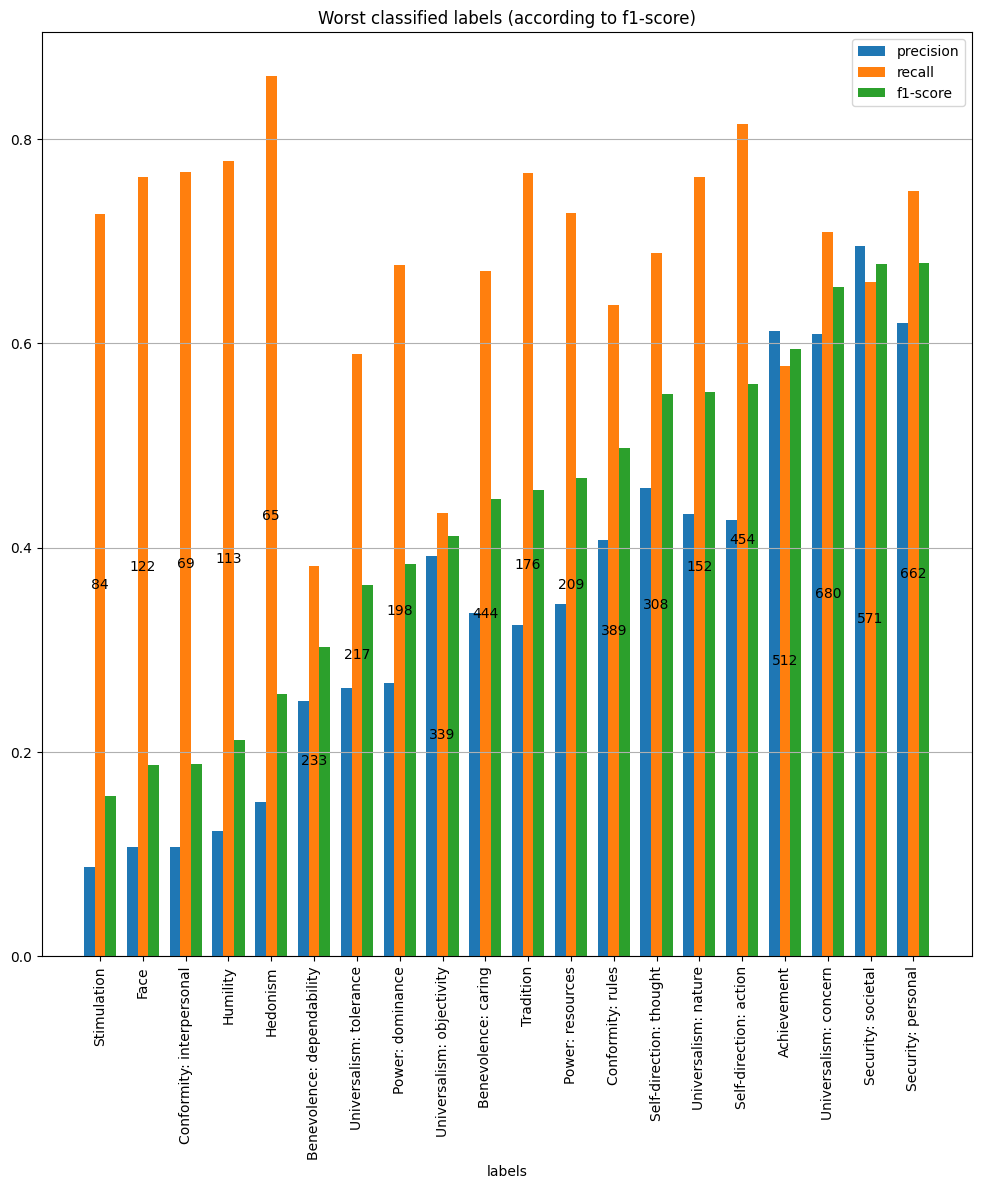

In [98]:
from typing import OrderedDict

class_report_sorted = sorted([(class_report_val[label]['f1-score'], label) 
                            for label in class_report_val.keys() if label in labels_train_df.columns.to_list() ])

class_report_sorted = OrderedDict({label:class_report_val[label] for (f1_score, label) in class_report_sorted})

# Number of classes to plot: the first `k` worst classes are plotted
#k = len(vocabulary_labels) if k is None else k
# Classes to plot
#tags_to_plot = [tag for i, tag in enumerate(class_report_sorted) if i<k]

plt.figure(figsize=(12,12))
x_axis = 2*np.arange(len(class_report_sorted))
plt.bar(x_axis-0.5, [class_report_sorted[tag]['precision'] for tag in class_report_sorted], label='precision', width=0.5)
b = plt.bar(x_axis, [class_report_sorted[tag]['recall'] for tag in class_report_sorted], label='recall', width=0.5)
plt.bar(x_axis+0.5, [class_report_sorted[tag]['f1-score'] for tag in class_report_sorted], label='f1-score', width=0.5)
plt.bar_label(b, labels=[class_report_sorted[tag]['support'] for tag in class_report_sorted], label_type='center')
plt.xticks(x_axis, list(class_report_sorted.keys()))
plt.grid(axis='y')
plt.legend()
plt.xticks(rotation=90)
plt.title('Worst classified labels (according to f1-score)')
plt.xlabel('labels')
plt.show()


In [86]:
from sklearn.metrics import multilabel_confusion_matrix
confusion_matrix = multilabel_confusion_matrix(y_true, y_pred).astype(np.float32)

print(confusion_matrix)

#confusion_matrix[,:]confusion_matrix[,:] / confusion_matrix.astype(np.float).sum(axis=(0, 1))


[[[1221.  251.]
  [  96.  212.]]

 [[ 829.  497.]
  [  84.  370.]]

 [[1061.  635.]
  [  23.   61.]]

 [[1400.  315.]
  [   9.   56.]]

 [[1080.  188.]
  [ 216.  296.]]

 [[1215.  367.]
  [  64.  134.]]

 [[1282.  289.]
  [  57.  152.]]

 [[ 878.  780.]
  [  29.   93.]]

 [[ 814.  304.]
  [ 166.  496.]]

 [[1044.  165.]
  [ 194.  377.]]

 [[1323.  281.]
  [  41.  135.]]

 [[1030.  361.]
  [ 141.  248.]]

 [[1270.  441.]
  [  16.   53.]]

 [[1035.  632.]
  [  25.   88.]]

 [[ 746.  590.]
  [ 146.  298.]]

 [[1280.  267.]
  [ 144.   89.]]

 [[ 791.  309.]
  [ 198.  482.]]

 [[1476.  152.]
  [  36.  116.]]

 [[1203.  360.]
  [  89.  128.]]

 [[1213.  228.]
  [ 192.  147.]]]


In [89]:
for i in range(confusion_matrix.shape[0]):
    confusion_matrix[i] = confusion_matrix[i] / confusion_matrix[i].sum()
    
print(confusion_matrix)


[[[0.68595505 0.14101124]
  [0.05393258 0.11910112]]

 [[0.46573034 0.2792135 ]
  [0.04719101 0.20786516]]

 [[0.5960674  0.35674158]
  [0.01292135 0.03426966]]

 [[0.78651685 0.1769663 ]
  [0.00505618 0.03146067]]

 [[0.60674155 0.10561798]
  [0.12134831 0.16629213]]

 [[0.6825843  0.20617977]
  [0.03595506 0.0752809 ]]

 [[0.72022474 0.16235955]
  [0.03202247 0.08539326]]

 [[0.49325842 0.43820226]
  [0.01629213 0.05224719]]

 [[0.45730338 0.17078651]
  [0.09325843 0.27865168]]

 [[0.58651686 0.09269663]
  [0.10898876 0.21179776]]

 [[0.7432584  0.15786517]
  [0.02303371 0.07584269]]

 [[0.57865167 0.20280899]
  [0.07921349 0.13932584]]

 [[0.71348315 0.24775282]
  [0.00898876 0.02977528]]

 [[0.58146065 0.35505617]
  [0.01404494 0.0494382 ]]

 [[0.41910112 0.33146068]
  [0.08202247 0.16741572]]

 [[0.71910113 0.15      ]
  [0.08089887 0.05      ]]

 [[0.444382   0.1735955 ]
  [0.11123595 0.27078652]]

 [[0.8292135  0.08539326]
  [0.02022472 0.06516854]]

 [[0.6758427  0.20224719]
  

ValueError: multilabel-indicator is not supported

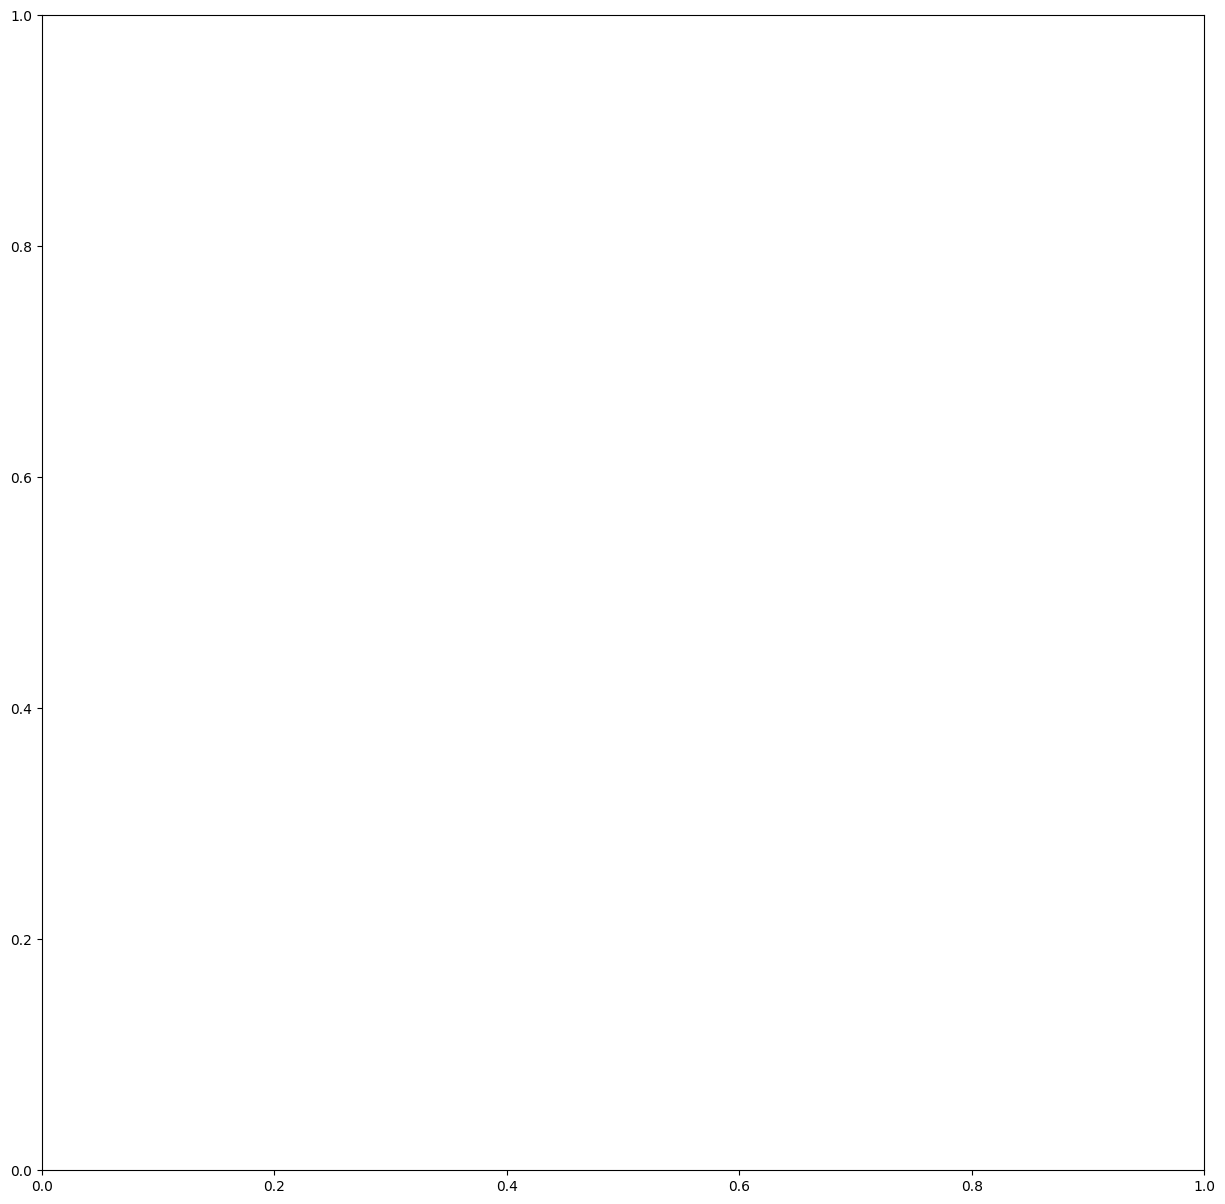

In [58]:
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(15,15))

confusion_matrix = ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=labels_train_df.columns.to_list(),
                                                           normalize='true', cmap=plt.cm.Blues, values_format=".2f",ax=ax)

confusion_matrix.ax_.get_images()[0].set_clim(0, 1)


In [55]:
from sklearn.metrics import f1_score

y_pred, y_true = predict(test_loader)
f1_macro = f1_score(y_true=y_true, y_pred=y_pred, average='macro')
print(f'Test f1-score macro on the validation set: {f1_macro:.3f}')

Test f1-score macro on the validation set: 0.430


In [101]:
from sklearn.metrics import classification_report

class_report_test = classification_report(y_true=y_true, y_pred=y_pred, target_names=labels_train_df.columns.to_list(),
                                     zero_division=0, output_dict=True)

print('Classification report for the validation set:')
print(classification_report(y_true=y_true, y_pred=y_pred,
                            target_names=labels_train_df.columns.to_list(), zero_division=0))

                            precision    recall  f1-score   support

   Self-direction: thought       0.30      0.82      0.44       251
    Self-direction: action       0.59      0.50      0.54       496
               Stimulation       0.14      0.42      0.21       138
                  Hedonism       0.22      0.45      0.30       103
               Achievement       0.59      0.77      0.67       575
          Power: dominance       0.26      0.37      0.31       164
          Power: resources       0.32      0.93      0.48       132
                      Face       0.12      0.47      0.20       130
        Security: personal       0.81      0.63      0.71       759
        Security: societal       0.61      0.72      0.66       488
                 Tradition       0.30      0.59      0.40       172
         Conformity: rules       0.46      0.60      0.52       455
 Conformity: interpersonal       0.14      0.27      0.18        60
                  Humility       0.12      0.37

In [41]:
# Defining the training function on the 80% of the dataset for tuning the distilbert model

def train(epoch):
    tr_loss = 0
    n_correct = 0
    nb_tr_steps = 0

    for i, data in enumerate(training_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        targets = data['labels'].to(device, dtype = torch.float32)
       
        outputs = model(ids, mask)
        
        loss = loss_function(outputs.logits, targets)
        tr_loss += loss.item()

        n_correct += calculate_accuracy(outputs.logits, targets)

        nb_tr_steps += 1
        
        if i % 5000==0:
            loss_step = tr_loss/nb_tr_steps
            accu_step = (n_correct * 100)/nb_tr_steps 
            print(f'Training Loss per 5000 steps: {loss_step}')
            print(f'Training Accuracy per 5000 steps: {accu_step}')

        optimizer.zero_grad()
        loss.backward()
        # # When using GPU
        optimizer.step()

    print(f'The Total Accuracy for Epoch {epoch}: {(n_correct * 100) / nb_tr_steps}')
    epoch_loss = tr_loss / nb_tr_steps
    epoch_accu = (n_correct * 100) / nb_tr_steps
    print(f"Training Loss Epoch {epoch}: {epoch_loss}")
    print(f"Training Accuracy Epoch {epoch}: {epoch_accu}")

    return 
     

In [42]:
for epoch in range(EPOCHS):
    model.train()
    train(epoch)

Training Loss per 5000 steps: 0.012279205955564976
Training Accuracy per 5000 steps: 88.7499988079071


KeyboardInterrupt: 